In [48]:
# Example to illustrate remote simulation
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

from remote_sim_plot_utils import plot_field_results
from pathlib import Path
plt.figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [49]:
# print json with indentation
def print_json(data, indent=4):
    print(json.dumps(data, indent=indent))


### Server APIs

In [50]:
DJANGO_SERVER_API = "http://127.0.0.1:8000/simapi/run-sim-json/"
CL_APP_SERVER_API = "http://127.0.0.1:8081/api/sim/run-sim-json"

### Project id key to run simulation

In order to perform a remote simulation, a user must first create a project_id key. The key corresponds describes a project and also corresponds to a particular simulation model.

In [51]:
# set a project_id key to run the xz-nz-model (model dimensions are 100x1x1 grid)
project_id = "084de6a9-03b8-4eb2-bbe6-3407eda32b20"

### Sample input file with parameters to run application

In [52]:
input_file = "sample-input-files/xz_nz_model_v2_formatted_valid.json"
with open(input_file) as f:
    input_data = json.dumps(json.load(f))

### Calling DJANGO Server Directly

In [53]:
response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
if response.status_code == 200:
    print('Success: Remote simulation job completed')
    print_json(response.json())
else:
    print('Failed: Remote simulation job failed')

Success: Remote simulation job completed
[
    {
        "real_id": 1,
        "status": "SUCCESS",
        "case": "case-246ef6346d71109",
        "job_start_time": "202193 15:59:42.495314 GMT-05:00",
        "job_end_time": "202193 15:59:45.769799 GMT-05:00",
        "duration": 3.2745188,
        "job_directory": "/tmp/simulations/case-246ef6346d71109",
        "deleted": "NO",
        "cum_oil": 602367.16,
        "npv": 7409165.5,
        "field_results": {
            "unit-system": "FIELD",
            "time-days": [
                0.0,
                1.0,
                2.978797,
                7.303366,
                13.25132,
                18.45103,
                24.72551,
                31.0,
                39.3457,
                49.17996,
                54.58998,
                60.0,
                69.11114,
                79.366416,
                85.183215,
                91.0,
                100.9639,
                110.981904,
                121.0

### Calling the application server directly

In [54]:
# Set parameters for sample call to application server
# Need to derive some of the other data from the database
# TODO: Update the application code so we derive that data from the database
# TODO: Reduce data that is specified as part of of the of input data
data = {
    "user-id": 1,
    "project-id": "084de6a9-03b8-4eb2-bbe6-3407eda32b20",
    "model-name": "xz-nz-model",
    "model-version": "v2.1.7",
    "model-directory": "apisds/production_models/v2.1.7/xz-nz-model/",
    "eval-host-ip": "localhost",
    "real-ids": [
        1
    ],
    "max-num-real": 1,
    "delete": "NO",
    "server-port": 50100,
    "json-file-data": input_data,
}
data = json.dumps(data)

In [55]:
# view sample data
print(data)

{"user-id": 1, "project-id": "084de6a9-03b8-4eb2-bbe6-3407eda32b20", "model-name": "xz-nz-model", "model-version": "v2.1.7", "model-directory": "apisds/production_models/v2.1.7/xz-nz-model/", "eval-host-ip": "localhost", "real-ids": [1], "max-num-real": 1, "delete": "NO", "server-port": 50100, "json-file-data": "{\"projectid\": \"66333aca-b53a-4ced-bf41-9c06a75bc643\", \"delete\": \"NO\", \"results\": [\"npv\", \"cop\"], \"parameters\": [[{\"welltype\": 0, \"heel\": [1, 1, 1], \"toe\": [1, 1, 1]}, {\"welltype\": 1, \"heel\": [50, 1, 1], \"toe\": [50, 1, 1]}, {\"welltype\": 0, \"heel\": [100, 1, 1], \"toe\": [100, 1, 1]}]]}"}


Success: Remote simulation job executed


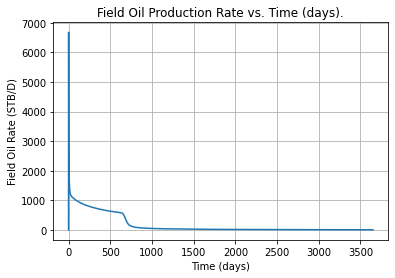

In [56]:
#headers = {'Content-type': 'application/x-www-form-urlencoded; charset=utf-8'}
response = requests.post(CL_APP_SERVER_API, data=data)
if response.status_code == 200:
    print('Success: Remote simulation job executed')
    response_json = response.json()
    # Extract the field results
    field_results = response_json[0]["field_results"]
    plot_field_results(field_results)
else:
    print('Failed: Remote simulation job failed')


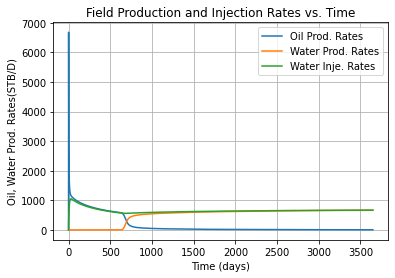

In [82]:
plot_field_results(field_results)
#field_results['water-prod-rates']

### Simulate multiple calls to remote servers - Serial vs Parallel call 

In [10]:
num_calls = 5

In [20]:
# call the django server
def run_django_server(num_calls=num_calls):
    django_durations = np.zeros(num_calls)
    for i in range(num_calls):
        response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
        results = response.json()
        django_durations[i] = results[0]['duration']
    return django_durations


NameError: name 'num_calls' is not defined

In [12]:
# call the application server 
def run_app_server(num_calls=num_calls):
    app_durations = np.zeros(num_calls)
    for i in range(num_calls):
        response = requests.post(CL_APP_SERVER_API, data=data)
        results = response.json()
        app_durations[i] = results[0]['duration']
    return app_durations


In [57]:
# make plot
def make_plot(df, title='Calls', out_filename='out.png'):
    plt.figure(figsize=(12, 10), dpi=80)
    fontsize=15
    plt.plot(df)
    plt.xlabel('Simulation Index', fontsize=fontsize)
    plt.ylabel('Duration (seconds)', fontsize=fontsize)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0, len(df)])
    plt.ylim([0, 10])
    plt.title(title,fontsize=fontsize)
    plt.legend(df.columns, fontsize=fontsize)
    plt.grid(True)
    if out_filename:
        plt.savefig('./output/' + out_filename)

In [29]:
# run simulations
def run_serial_test(num_calls=num_calls):
    django_durations = run_django_server(num_calls)
    app_durations    = run_app_server(num_calls)
    df = pd.DataFrame({'CALL_APP_VIA_DJANGO' : django_durations, 'CALL_APP_DIRECTLY' : app_durations})
    make_plot(df, title='Serial Remote Calls')
    return df

def run_app_serial_test(num_calls=num_calls):
    app_durations    = run_app_server(num_calls)
    df = pd.DataFrame({'CALL_APP_DIRECTLY' : app_durations})
    make_plot(df, title='Serial Remote Calls')
    return df


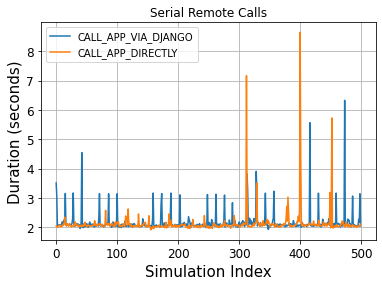

In [30]:
df = run_serial_test(500)

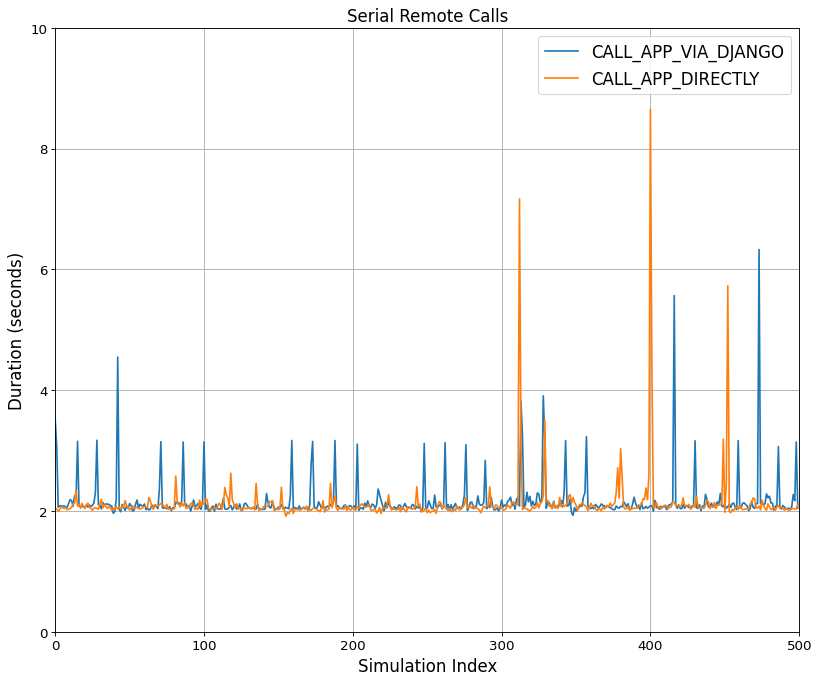

In [58]:
make_plot(df, 'Serial Remote Calls', 'serial_remote_calls_500.png')

In [51]:
df.to_csv('./output/serial_remote_calls_500.csv', index=False)